# Lab 7: Recurrent Neural Networks

Nick Chao

#### Dataset Selection

Select a dataset similarly to lab one:text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

#### Preparation (30 points total)
[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

#### Modeling (50 points total)
[15 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

[15 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

[20 points] Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

#### Exceptional Work (10 points total)
You have free reign to provide additional analyses.
One idea (required for 7000 level students): Use t-SNE (or SVD) to visualize the word embeddings of a subset of words in your vocabulary. Try to interpret what each dimension reflects (in your own words). That is, try to explain what aspect of the language is encoded in the reduced dimensionality embedding. 
Another Idea (NOT required): Try to create a RNN for generating novel text. 

### Data Overview

The dataset I will be using is video game reviews from Amazon. This dataset has approximately 231,780 reviews and is a k-core subset of the complete dataset. This data comes from the 5-score subset in which all users and items have at least 5 reviews. These reviews include ratings, text, and helpfulness votes. It also contains metadata related to the products.

More information about the dataset can be found here: http://jmcauley.ucsd.edu/data/amazon/

### Prediction Task

Reviews have become increasingly more crucial in consumer purchases over the years. They are trusted by the public as they are written by the public. According to https://www.entrepreneur.com/article/253361, 70 percent of global consumers trust online reviews. Even more so, Amazon reviews are some of the most common destination for consumers to start researching their desired products. Without a doubt, online reviews are becoming more and more important in the global market. As reviews become more and more common during consumer research, so do ratings. 

Ratings are the first thing that consumers see when they begin their research and typically focus on the reviews of the polar ratings (5 stars vs 1 star). If there are enough of these polar ratings then a consumer may not even bother reading reviews as they trust the authors. This means that businesses must montior their products to see what consumers deem 5 star and what they deem to be 1 star. Knowing this information can help these businesses develop more consumer happy products or remediate a consumer's unhappy product experience. The better the rating for a product, the more likely it is a consumer will buy the product.

Even though Amazon proivides a rating system for their consumer reviews, other sources do not. For example, relating to this dataset of video games, there are many sources where players can write reviews but do not provide a star rating. These type of reviews are helpful to consumers as they determine if a video game is worth purchasing or not. The goal of my prediction task is to see if it is possible to determine the rating of a review based on the text an author writes. As the ultimate goal of reading video game reviews is to either buy the game or not, this will be a binary classification task where a 5-star review is buy and a 1-star review is don't buy. 

In [1]:
# Dependancies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
import copy
from sklearn import metrics as mt
from keras.models import Sequential
from keras.layers import TimeDistributed, Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import LSTM, GRU
from keras.models import Model
from keras.optimizers import SGD, Adagrad, Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, make_scorer

import warnings
warnings.filterwarnings('ignore')

/usr/local/es7/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the dataset
df = pd.read_json('../data/reviews_Video_Games_5.json', lines=True)

In [3]:
# lets take a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231780 entries, 0 to 231779
Data columns (total 9 columns):
asin              231780 non-null object
helpful           231780 non-null object
overall           231780 non-null int64
reviewText        231780 non-null object
reviewTime        231780 non-null object
reviewerID        231780 non-null object
reviewerName      228967 non-null object
summary           231780 non-null object
unixReviewTime    231780 non-null int64
dtypes: int64(2), object(7)
memory usage: 17.7+ MB


In [4]:
df.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


In [5]:
print('Number of reviews:''Number',len(df.overall))
print('Number of 5 star reviews:',sum(df.overall==5))
print('Number of 4 star reviews:',sum(df.overall==4))
print('Number of 3 star reviews:',sum(df.overall==3))
print('Number of 2 star reviews:',sum(df.overall==2))
print('Number of 1 star reviews:',sum(df.overall==1))

Number of reviews:Number 231780
Number of 5 star reviews: 120185
Number of 4 star reviews: 54804
Number of 3 star reviews: 28275
Number of 2 star reviews: 13663
Number of 1 star reviews: 14853


### Evaluation Metric

Looking at the number of reviews, nearly half of them are 5-star and only about 6% of the reviews are 1 star. As I believe the negative reviews are just as important to a bussiness (because they offer constructive critism for growth) as positive reviews, I need to figure out how to balance these polar ratings. To help balance the good reviews with the bad reviews I will be combining the number of 1 and 2 star reviews into a single class. I will also be ignoring 3 and 4 star reviews. This leaves about 19.2% of the remaining reviews as negative and 80.8% of reviews as positive.

Because my data is still severely imbalanced and I feel that negative reviews are important and helpful to both consumers and businesses than positive reviews, I will be using a weighted F-Score to evaluate my model. F-Score utilizes both precision and recall for its metric. The weighted portion will help take into account the limited supply of negative reviews.

##### Recall
A good recall is the ability to mark as many of the N-star reviews as a N-star rating. For example, if we were looking for all the 5-star reviews then a good recall would mark as many of them as 5-star as possible. Furthermore, a perfect recall model, when given a N-star rating, will identify every review that is an N-star rating. However, it should be noted that this does not mean that every N-star review that is marked as a N-star rating is infact an N-star rating. This part of the F-score is focused on reducing false negatives. In this case, good recall is the ability for the model to identify all N-star reviews as N-star ratings.


###### Precision
Precision compliments recall as it concerns whether the model was correct or not. For example, a model with high precision on a certain rating will be accurate when it claims that a review is that specific rating. Perfect precision means you can trust that the model knows when a "duck is a duck". However, precision does not concern iteself with ensuring that it identifies all the reviews correctly. In this case, good precision is the ability for the model to be correct when it claims a N-star review is an N-star rating. It is not concerned with catching all the reviews for a specific rating, only that when it determins a specific rating for a review, it is correct. This is important to this business case because we wouldn't want mislabeled reviews. Good reviews mislabled as bad reviews would waste the time of whomever was in charge of remiediating bad user experience for the video games. Not only that but bad reviews labeled good would be filtered out by the business as they would assume everything is doing ok when in reality there could be something terrible about a video game (bug or UX) situation. 


In [6]:
# Start by getting rid of any nulls
df = df[pd.notnull(df['overall'])]

In [7]:
# Replacing rating 2s with rating 1s
# Also replacing 4s with 3 to remove later
df.overall.replace([1, 2, 3, 4, 5], [1, 1, 3, 3, 5],
                  inplace = True)

In [8]:
# Removing 3s and 4s from the datset
df = df[df.overall != 3]

In [9]:
print('Number of reviews:''Number',len(df.overall))
print('Number of 5 star reviews:',sum(df.overall==5), '     Percentage: ', (sum(df.overall==5) / len(df.overall)))
print('Number of 4 star reviews:',sum(df.overall==4))
print('Number of 3 star reviews:',sum(df.overall==3))
print('Number of 2 star reviews:',sum(df.overall==2))
print('Number of 1 star reviews:',sum(df.overall==1), '     Percentage: ', (sum(df.overall==1) / len(df.overall)))

Number of reviews:Number 148701
Number of 5 star reviews: 120185      Percentage:  0.8082326278908682
Number of 4 star reviews: 0
Number of 3 star reviews: 0
Number of 2 star reviews: 0
Number of 1 star reviews: 28516      Percentage:  0.19176737210913175


### Training and Testing

After removing nearly half the data during pre-processing, I will need to utilize a test splitting method to accomadate the smaller subset of data. I have decided to use Stratified 10-fold cross validation for splitting my data into training and testing subsets. The advanatage of using this type of method is that all of the data is eventually used for both training and testing and it is only used once. Stratification ensures that each fold of my data is adaquently represented and is the correct proportion. 

Unfortunately I was unable to get stratified k fold to work. Although I don't believe train_test_split is the best choice, I do believe it will be effective during my validation. 

### Preprocessing Continued...

The first thing I have done is change all rating 2 reviews to rating 1 reviews as they are both deemed negative. Next I removed all reviews that were not labled polar (1 or 5). I want to also convert this to binary as I believe it will be easier that way later on (0 for bad review, don't buy the game, 1 for good review, buy the game)

I will also check (and remove if neccessary) if there are any duplicate reviews as this would falsely skew my validation later on. I will also remove any entrees that do not have a review as this would not help with my predicition task.

In [10]:
df.overall.replace([1, 5], [0, 1],
                  inplace = True)

In [11]:
# Checking for dupplicate entrees by comparing the product ID with the reviewer ID. 
# Dupplicates would be from the same reviewer on the same product
print(len(df[df.duplicated(['asin', 'reviewerID'])]))

0


In [12]:
# There are no dupplicates but we still need to make sure we don't have missing data for reviews
#df.head()
df = df[pd.notnull(df['reviewText'])]
len(df)

148701

In [13]:
# Lets also get rid of some of the columns that we for sure don't need

del df['reviewTime']
del df['helpful']
del df['unixReviewTime']

In [14]:
# Let's convert the ratings to binary now
df['overall'] = df['overall'].astype('bool')

In [15]:
#Lets take a look at a random review
random_index = np.random.choice(df.index)
print('Rating (0-1):', + df.overall[random_index])
print('Review: ',(df.reviewText[random_index]))

Rating (0-1): True
Review:  What can I say about Playstation Plus? There's something wrong with you if you don't have it.I don't mean to offend anyone, but seriously - why wouldn't you have a plus account? You get access to exlusive discounts, invited to try out betas for certain games, and best of all, you get to take part in the instant game collection where every month you get free games. Did you hear me? FREE!And no, these aren't just crappy games either. Some of the best selling games on the system have appeared on Playstation Plus's IGC, including Dragon's Dogma, Infamous 2, and coming this month, Borderlands 2!If you have a Playstation 4 then yes, you are required to have a plus account to play a majority of the games online, but you still get access to every bonus they release for PS3 and Vita as well!Seriously, stop reading this, click on &#34;purchase&#34; and go download some free games!


Looks like there weren't any empty reviews so we can move on to training. 
Below is a look at the final dataset

    asin: Product ID 
    helpful: Tuple containing the number of people who found the review helpful versus not helpful (deleted)
    overall: The rating (0 or 1)
    reviewText: The actual review
    reviewTime: The timestamp of the review (deleted)
    reviewerID: ID of the reviewer
    reviewerName: The reviewer's name
    summary: Summary of the review
    unixReviewTime: Timestamp of the review (deleted)

In [16]:
df.head()

,asin,overall,reviewText,reviewerID,reviewerName,summary
0,0700099867,False,Installing the game was a struggle (because of...,A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.
2,0700099867,False,1st shipment received a book instead of the ga...,A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key
6,0700099867,True,Loved playing Dirt 2 and I thought the graphic...,AN3YYDZAS3O1Y,Bob,A step up from Dirt 2 and that is terrific!
7,0700099867,False,I can't tell you what a piece of dog**** this ...,AQTC623NCESZW,Chesty Puller,Crash 3 is correct name AKA Microsoft
9,0700099867,False,I still haven't figured this one out. Did ever...,A2JLT2WY0F2HVI,D. Sweetapple,Couldn't get this one to work


## Modeling

In [17]:
# from https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras# from h 

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [18]:
# Modified from https://github.com/eclarson/MachineLearningNotebooks/blob/master/13.%20RNN%20Basics.ipynb

NUM_TOP_WORDS = None
MAX_ART_LEN = 1000 # maximum and minimum number of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df.reviewText.values)
sequences = tokenizer.texts_to_sequences(df.reviewText.values)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 170399 unique tokens. Distilled to 170399 top words.


In [20]:
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
y = df['overall']

y_ohe = keras.utils.to_categorical(y)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Shape of data tensor: (148701, 1000)
Shape of label tensor: (148701, 2)
170399


In [21]:
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=df.overall, 
                                                            random_state=42)
NUM_CLASSES = 20
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(118960, 1000) (118960, 2)
[22813. 96147.]


In [22]:
%%time

# from https://github.com/eclarson/MachineLearningNotebooks/blob/master/13.%20RNN%20Basics.ipynb

EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('../data/glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(170400, 100)
CPU times: user 11 s, sys: 335 ms, total: 11.3 s
Wall time: 11.3 s


In [23]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [24]:
# LSTM Model

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(2, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy', f1])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         17040000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 17,120,602
Trainable params: 80,602
Non-trainable params: 17,040,000
_________________________________________________________________
None


In [27]:
history_rnn_lstm = rnn.fit(X_train, y_train_ohe, 
                           validation_data=(X_test, y_test_ohe), 
                           epochs=3, 
                           batch_size=1000)

Train on 118960 samples, validate on 29741 samples
Epoch 1/3
118960/118960 [==============================] - 538s 5ms/step - loss: 0.4170 - acc: 0.8164 - f1: 0.8019 - val_loss: 0.3899 - val_acc: 0.8300 - val_f1: 0.8286
Epoch 2/3
118960/118960 [==============================] - 598s 5ms/step - loss: 0.3618 - acc: 0.8427 - f1: 0.8093 - val_loss: 0.2983 - val_acc: 0.8766 - val_f1: 0.8447
Epoch 3/3
118960/118960 [==============================] - 652s 5ms/step - loss: 0.3069 - acc: 0.8715 - f1: 0.8054 - val_loss: 0.2633 - val_acc: 0.8952 - val_f1: 0.7789


In [28]:
# GRU Model

rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(GRU(100,dropout=0.2, recurrent_dropout=0.2))
rnn2.add(Dense(2, activation='sigmoid'))
rnn2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy', f1])
print(rnn2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         17040000  
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 17,100,502
Trainable params: 60,502
Non-trainable params: 17,040,000
_________________________________________________________________
None


In [29]:
history_rnn_gru = rnn2.fit(X_train, y_train_ohe, 
                           validation_data=(X_test, y_test_ohe), 
                           epochs=3, 
                           batch_size=1000)

Train on 118960 samples, validate on 29741 samples
Epoch 1/3
118960/118960 [==============================] - 606s 5ms/step - loss: 0.4372 - acc: 0.8138 - f1: 0.8129 - val_loss: 0.3287 - val_acc: 0.8518 - val_f1: 0.8505
Epoch 2/3
118960/118960 [==============================] - 589s 5ms/step - loss: 0.3111 - acc: 0.8686 - f1: 0.8088 - val_loss: 0.2460 - val_acc: 0.8983 - val_f1: 0.8081
Epoch 3/3
118960/118960 [==============================] - 622s 5ms/step - loss: 0.2620 - acc: 0.8932 - f1: 0.7826 - val_loss: 0.2273 - val_acc: 0.9086 - val_f1: 0.7622


In [30]:
# Modified from https://github.com/eclarson/MachineLearningNotebooks/blob/master/11.%20Convolutional%20Neural%20Networks.ipynb

def confusion_rnn(rnn, X_test, y_test, title):
#     plt.figure(figsize=(15,5))
#     if rnn is not None:
#         yhat = np.argmax(rnn.predict(X_test), axis=1)
#         f1_rnn = mt.f1_score(y_test,yhat, average="macro")
#         acc_rnn = mt.accuracy_score(y_test,yhat)
#         plt.subplot(1,2,1)
#         cm = mt.confusion_matrix(y_test,yhat)
#         cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
#         sns.heatmap(cm, annot=True, fmt='.2f')
#         plt.title(str(title) + '   RNN_acc: '+str(acc_cnn) + '   RNN_F1: ' +str(f1_cnn))

    yhat = np.argmax(rnn.predict(X_test), axis=1)
    y_test = np.argmax(y_test_ohe, axis = 1)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    acc = mt.accuracy_score(y_test,yhat)
    f1 = mt.f1_score(y_test,yhat, average="macro")
    plt.title("Using " + str(title) + ": " +' Acc: {:.4f}'.format(acc) + ' F1: {:.4f}'.format(f1))
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.show()

In [31]:
confusion_rnn(rnn, X_test, y_test, 'lstm')

NameError: name 'y_test' is not defined

In [ ]:
confusion_rnn(rnn2, X_test, y_test, 'GRU')

In [70]:
%matplotlib inline

def plotHistory(model):
    plt.figure(figsize=(20, 10))
    plt.subplot(3,2,1)
    plt.plot(model.history['f1'])
    plt.title('Training')
    plt.ylabel('F1 %')
    plt.xlabel('epochs')


    plt.subplot(3,2,2)
    plt.plot(model.history['val_f1'])
    plt.title('Validation')
    plt.xlabel('epochs')

    plt.subplot(3,2,3)
    plt.plot(model.history['acc'])
    plt.ylabel('Accuracy %')
    plt.xlabel('epochs')

    plt.subplot(3,2,4)
    plt.plot(model.history['val_acc'])
    plt.xlabel('epochs')
    
    plt.subplot(3,2,5)
    plt.plot(model.history['loss'])
    plt.ylabel('cross-entropy loss %')
    plt.xlabel('epochs')

    plt.subplot(3,2,6)
    plt.plot(model.history['val_loss'])
    plt.xlabel('epochs')


#loss: 0.3495 - acc: 0.8522 - f1: 0.8353 - val_loss: 0.2329 - val_acc: 0.9037 - val_f1: 0.8806

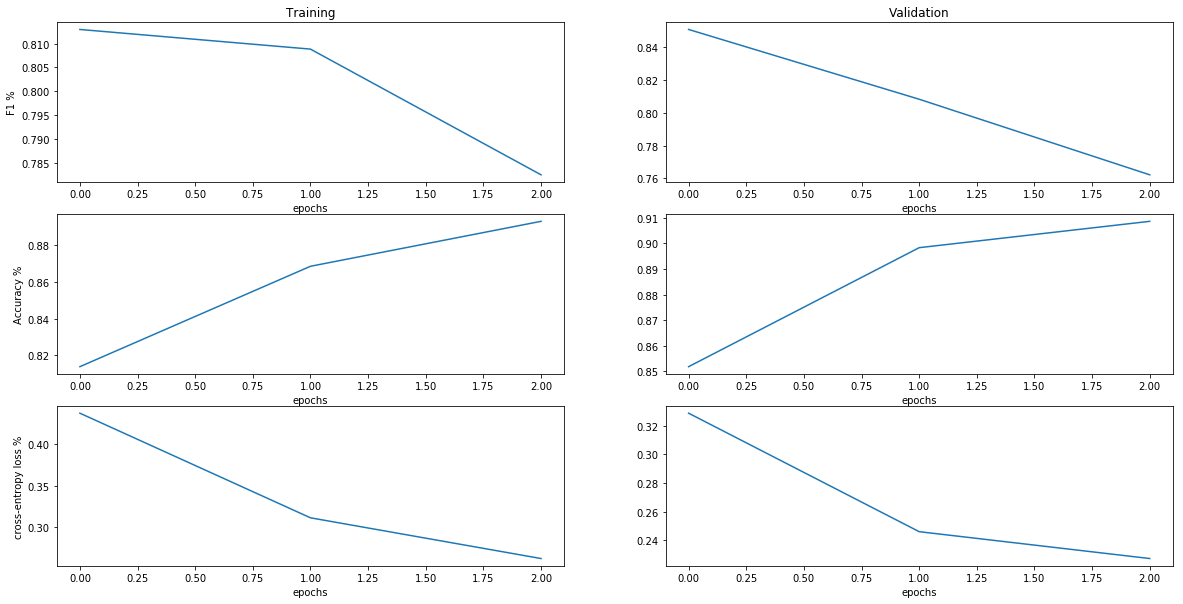

In [71]:
plotHistory(history_rnn_gru)

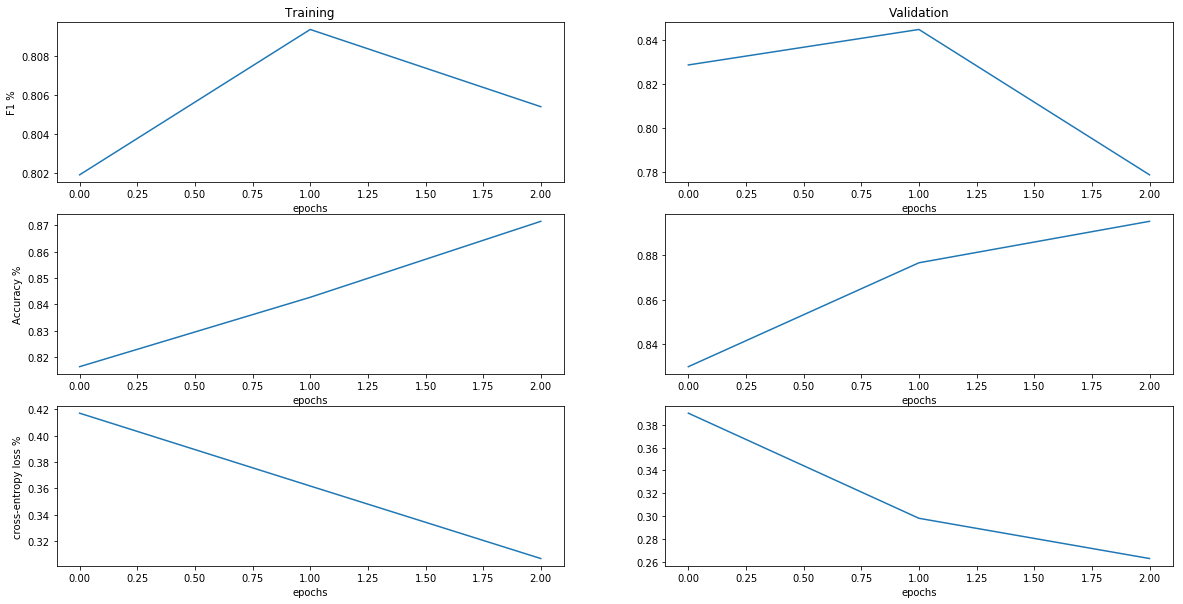

In [72]:
plotHistory(history_rnn_lstm)